# Influential Thinkers 
Authors:
* Paul Roussel
* Augustin Espinosa
* Clément Liu
* Pierre Fontaine
* Runtian Zhang

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)

## Introduction

In this project, we are interested in the thinkers who have influenced the history of mankind. We know that a thinker is inspired by some of his predecessors and will also influence his successors. The aim of this project is to determine the existence of an influence of thought between two people.

![graph](img/graph.png)

# Data

## Link between thinkers

This dataset was built from  [DBpedia](https://wiki.dbpedia.org/) which is a public database-like, indexed version of Wikipedia.  
Each row represents a couple of two thinkers:
   * `index` - arbitrary but unique integer identifier for a couple
   * `thinker_1` - name of the first thinker
   * `thinker_2` - name of the first thinker
   * `link` - 1 if tinker_1 has influenced thinker_2, 0 otherwise

## Thinkers data

Using the [Wikipedia-API](https://pypi.org/project/Wikipedia-API/), data about the thinkers of the dataset is gathered.
Each row represents a thinker:
   * `name`
   * `date_birth` - `date_death`: dates of birth and death (if known)
   * `place_birth` - `place_death`: places of birth and death (if known)
   * `summary`: Abstract extracted from the Wikipedia page of the corresponding author

## Training and test

The thinkers graph dataset has been split into 'training' and 'test' subsets. The shapes are:

* training: (2 3296, 5)
* test: (520 966, 5)

## Score metric

We use the precision score to evaluate the performance:

$precision = \frac{True Positive}{True Positive + False Positive}$

# Data exploration

In [1]:
%matplotlib inline
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import nltk
import re
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

In [2]:
df_train = pd.read_csv('data/train.csv', index_col=0)
df_test = pd.read_csv('data/test.csv', index_col=0)

In [9]:
data = pd.read_csv('data/nodes_info_new.csv', index_col = 0)

In [4]:
data.columns

Index(['id', 'thinker', 'birth_date', 'birth_place', 'death_date',
       'death_place', 'summary'],
      dtype='object')

## Preprocessing

In [5]:
#The date information are in format of string which is very dirty. we define this funtion to clean the date, which might not be 100% accurate.
def clean_date(s):
    s = re.sub('[^0-9]', '', str(s))
    if len(s)==0:
        return np.nan
    if s == '1':
        return np.nan
    if len(s)<4:
        date = int(s)
    else:
        date = int(s[:4])
        if date>2000:
            date = int(s[:3])
    return date

data['birth_date'] = data['birth_date'].apply(clean_date)
data['death_date'] = data['death_date'].apply(clean_date)

In [6]:
data.head()

,id,thinker,birth_date,birth_place,death_date,death_place,summary
0,1,Ferdinand de Saussure,1857.0,"Geneva, Switzerland",1913.0,"Vufflens-le-Château, Canton of Vaud|Vaud, Swit...",Ferdinand de Saussure (; French: [fɛʁdinɑ̃ də ...
1,2,Georg Wilhelm Friedrich Hegel,827.0,"Stuttgart, Duchy of Württemberg",1831.0,"Berlin, Kingdom of Prussia",Georg Wilhelm Friedrich Hegel (; German: [ˈɡeː...
2,3,Sigmund Freud,1856.0,"Freiberg in Mähren, Moravia, Austrian Empire<b...",1939.0,"Hampstead, London, United Kingdom",Sigmund Freud ( FROYD; German: [ˈziːkmʊnt ˈfʁɔ...
3,4,Benjamin Tucker,1854.0,"South Dartmouth, Massachusetts, United States",1939.0,Monaco,"Benjamin Ricketson Tucker (; April 17, 1854 – ..."
4,5,Brian O'Nolan,1911.0,"Strabane, County Tyrone, Ireland",1966.0,"Dublin, Ireland",Brian O'Nolan (Irish: Brian Ó Nualláin; 5 Octo...


In [7]:
#Extracting country by taking the last word from birth_place and death_place
def get_country(s):
    s = re.sub('[^a-zA-Z ]', '', str(s))
    if len(s)==0:
        return np.nan
    return s.split()[-1]
data['birth_place'] = data['birth_place'].apply(get_country)
data['death_place'] = data['death_place'].apply(get_country)

In [8]:
data.head()

,id,thinker,birth_date,birth_place,death_date,death_place,summary
0,1,Ferdinand de Saussure,1857.0,Switzerland,1913.0,Switzerland,Ferdinand de Saussure (; French: [fɛʁdinɑ̃ də ...
1,2,Georg Wilhelm Friedrich Hegel,827.0,Wrttemberg,1831.0,Prussia,Georg Wilhelm Friedrich Hegel (; German: [ˈɡeː...
2,3,Sigmund Freud,1856.0,Republic,1939.0,Kingdom,Sigmund Freud ( FROYD; German: [ˈziːkmʊnt ˈfʁɔ...
3,4,Benjamin Tucker,1854.0,States,1939.0,Monaco,"Benjamin Ricketson Tucker (; April 17, 1854 – ..."
4,5,Brian O'Nolan,1911.0,Ireland,1966.0,Ireland,Brian O'Nolan (Irish: Brian Ó Nualláin; 5 Octo...


In [9]:
data.nunique()

id             7239
thinker        7239
birth_date      853
birth_place     705
death_date      727
death_place     519
summary        6883
dtype: int64

In [10]:
data.dtypes

id               int64
thinker         object
birth_date     float64
birth_place     object
death_date     float64
death_place     object
summary         object
dtype: object

In [11]:
data.isna().sum()/data.shape[0]

id             0.000000
thinker        0.000000
birth_date     0.119768
birth_place    0.124188
death_date     0.402404
death_place    0.433762
summary        0.000138
dtype: float64

C:\Users\auges\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\auges\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


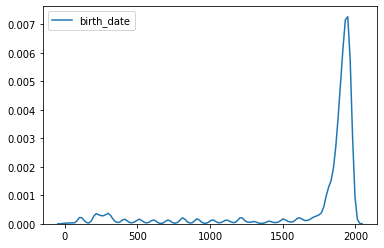

In [12]:
#Distribution of the birth date
sns.kdeplot(data['birth_date'])

In [13]:
#Counting according to birth place
data['birth_place'].value_counts().head()

US         1047
England     571
States      358
Empire      318
France      233
Name: birth_place, dtype: int64

## Integrating the node information into training data

In [14]:
#defining a dictionary which contains information for each thinker according to their names
thinker_dictionary = {}
for i,row in data.iterrows():
    thinker_dictionary[row['thinker']] = {'thinker_id': row['id'], 'birth_date': row['birth_date'], 'birth_place': row['birth_place'], 'death_place': row['death_place'], 'death_date': row['death_date'], 'summary': row['summary']}

In [15]:
#Integrating node information from full_wiki_data to train and test
def integrate_data(df, thinker_dictionary=thinker_dictionary):
    df_new = df.copy()
    feature_names = ['thinker_id', 'birth_date', 'birth_place', 'death_place', 'death_date', 'summary']
    for feature_name in feature_names:
        dtype = 'object'
        if 'date' in feature_name:
            dtype = 'float64'
        df_new[feature_name+'_1'] = pd.Series(dtype=dtype)
        df_new[feature_name+'_2'] = pd.Series(dtype=dtype)
        for i in df_new.index:
            try:
                df_new.at[i,feature_name+'_1'] = thinker_dictionary[df_new.loc[i,'thinker_1']][feature_name]
            except:
                pass
            try:
                df_new.at[i,feature_name+'_2'] = thinker_dictionary[df_new.loc[i,'thinker_2']][feature_name]
            except:
                pass
    return df_new

In [16]:
#Do the transformation for train and test
df_train=integrate_data(df_train)
df_test=integrate_data(df_test)

In [17]:
df_train.head()

,index,thinker_1,thinker_2,link,thinker_id_1,thinker_id_2,birth_date_1,birth_date_2,birth_place_1,birth_place_2,death_place_1,death_place_2,death_date_1,death_date_2,summary_1,summary_2
0,25830,Barnett Newman,Robert Ryman,1,2369,4569,1905.0,1930.0,City,US,City,US,1970.0,201.0,"Barnett Newman (January 29, 1905 – July 4, 197...","Robert Ryman (May 30, 1930 – February 8, 2019)..."
1,6536,Rainer Maria Rilke,Jim Starlin,0,234,2450,1875.0,1949.0,AustriaHungary,Michigan,Switzerland,NaN,1926.0,NaN,René Karl Wilhelm Johann Josef Maria Rilke (4 ...,"James P. Starlin (born October 9, 1949) is an ..."
2,6223,John Steinbeck,Ed Vega,1,2142,6222,227.0,1936.0,US,Rico,US,York,1968.0,200.0,"John Ernst Steinbeck Jr. (; February 27, 1902 ...","Edgardo Vega Yunqué (May 20, 1936 – August 26,..."
3,533,Herbert Spencer,Augusto dos Anjos,1,386,6479,1820.0,1884.0,England,Brazil,England,Brazil,1903.0,1914.0,Herbert Spencer (27 April 1820 – 8 December 19...,Augusto de Carvalho Rodrigues dos Anjos (April...
4,21051,Kostas Axelos,Ivan Illich,0,274,745,1924.0,1926.0,Athens,Austria,Paris,Germany,201.0,200.0,Kostas Axelos (also spelled Costas Axelos; Gre...,Ivan Illich (; 4 September 1926 – 2 December 2...


## Adding extra feature and some exploration

In [18]:
# Difference between dates of birth/death of each pair of thinkers
df_train['birth_date_dif'] = df_train.apply(lambda x: abs(x.birth_date_1-x.birth_date_2), axis=1)
df_test['birth_date_dif'] = df_test.apply(lambda x: abs(x.birth_date_1-x.birth_date_2), axis=1)

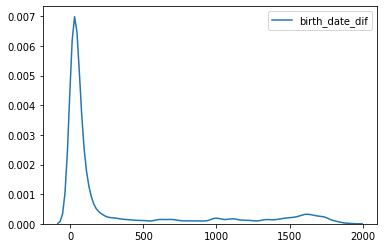

In [19]:
# Distribution of birth date difference for pairs of thinkers with a link
sns.kdeplot(df_train[df_train['link']==1]['birth_date_dif'])

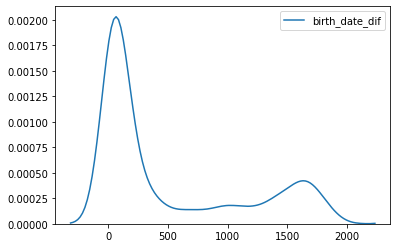

In [20]:
# Distribution of birth date difference for pairs of thinkers without a link
sns.kdeplot(df_train[df_train['link']==0]['birth_date_dif'])

In [21]:
# Creating another feature of if the two thinkers are from the same country
def same_country(s1, s2):
    if isinstance(s1, float) or isinstance(s2, float):
        return np.nan
    return int(s1==s2)
df_train['same_country'] = df_train.apply(lambda x: same_country(x.birth_place_1,x.birth_place_2), axis=1)
df_test['same_country'] = df_test.apply(lambda x: same_country(x.birth_place_1,x.birth_place_2), axis=1)

In [22]:
print(df_train['same_country'].value_counts())

0.0    17112
1.0     2423
Name: same_country, dtype: int64


In [23]:
# Thinkers with link
df_train[df_train['link']==1]['same_country'].value_counts()

0.0    7906
1.0    1934
Name: same_country, dtype: int64

In [24]:
# Thinkers without link
df_train[df_train['link']==0]['same_country'].value_counts()

0.0    9206
1.0     489
Name: same_country, dtype: int64

# Graph properties

The database of thinkers is actually a big graph : 

each thinker can be thought as a node of the graph and there is an edge between two thinkers if one has influenced the other.

Strictly speaking, it is a directed graph, but we don't have information on who influenced who in the database. We will therfore have an undirected graph.

In [25]:
import networkx as nx
from networkx.drawing.nx_pylab import draw_networkx

Let's take a look at a portion of the graph (only the 100 first thinkers)

In [26]:
# Small graph
small_nodes = np.arange(1,100)

small_edges = df_train[df_train['link']==1][(df_train['thinker_id_1']<100)&(df_train['thinker_id_2']<100)][['thinker_id_1','thinker_id_2']]

small_G = nx.Graph()
small_G.add_nodes_from(small_nodes)
small_G.add_edges_from(small_edges.values)

C:\Users\auges\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


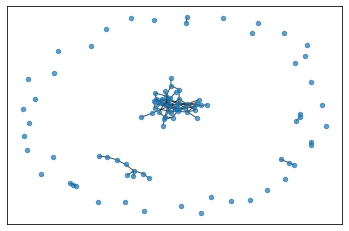

In [27]:
#Careful not to plot big graphs
draw_networkx(small_G,with_labels=False,node_size=20,alpha=0.7)

We see that the graph appears to have one big group in the middle where all the thinkers seem to have influenced each other in one way or another. There also seems to be small distinct thinking beliefs in the fringe and a large number of thinkers who coexist without citing each other.

# Predictions

The submission is made with two files: `feature_extractor.py` built with the `FeatureExtractor` class, and `regressor.py` built with the `Regressor` class.

## Feature extractor

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import nltk
import networkx as nx
from networkx.drawing.nx_pylab import draw_networkx
from networkx.algorithms.centrality import degree_centrality,eigenvector_centrality,closeness_centrality
from networkx.algorithms.centrality import betweenness_centrality,subgraph_centrality


class FeatureExtractor(object):
    def __init__(self):
        nltk.download('punkt') # for tokenization
        nltk.download('stopwords')
        self.stpwds = set(nltk.corpus.stopwords.words("english"))
        self.stemmer = nltk.stem.PorterStemmer()
        self.G = nx.Graph()
        self.nodes = None
        self.edges = None

    def fit(self, X_df, y_array):
        
        y_array = pd.DataFrame(y_array)
        y_array.columns = ['link']
        
        path = os.path.dirname(_file_)
        self.data = pd.read_csv(os.path.join(path, 'data/nodes_info_new.csv'),low_memory=False)
        
        def clean_date(s):
            s = re.sub('[^0-9]', '', str(s))
            if len(s)==0:
                return np.nan
            if s == '1':
                return np.nan
            if len(s)<4:
                date = int(s)
            else:
                date = int(s[:4])
                if date>2000:
                    date = int(s[:3])
            return date

        self.data['birth_date'] = self.data['birth_date'].apply(clean_date)
        self.data['death_date'] = self.data['death_date'].apply(clean_date)
        
        def get_country(s):
            s = re.sub('[^a-zA-Z ]', '', str(s))
            if len(s)==0:
                return np.nan
            return s.split()[-1]
        
        self.data['birth_place'] = self.data['birth_place'].apply(get_country)
        self.data['death_place'] = self.data['death_place'].apply(get_country)
        
        
        #defining a dictionary which contains information for each thinker according to their names
        self.thinker_dictionary = {}
        for i,row in self.data.iterrows():
            self.thinker_dictionary[row['thinker']] = {'thinker_id': row['id'], 'birth_date': row['birth_date'], 'birth_place': row['birth_place'], 'death_place': row['death_place'], 'death_date': row['death_date'], 'summary': row['summary']}
        
        
        
        max_id = self.data['id'].max()
        self.nodes = np.arange(1,max_id+1)
        
        self.edges = np.array([[self.thinker_dictionary[row['thinker_1']]['thinker_id'],self.thinker_dictionary[row['thinker_2']]['thinker_id']] for i,row in (X_df.loc[(y_array['link']==1).values.flatten(),:]).iterrows()])
        
        self.G.add_nodes_from(self.nodes)
        self.G.add_edges_from(self.edges)
        
        self.graph_features = pd.DataFrame({'thinker_id':self.nodes})
        self.connected_comp = list(nx.connected_components(self.G))
        
        group_id = {}
        group_len = {}
        for think_id in self.nodes:
            for i,group in enumerate(self.connected_comp):
                if think_id in group:
                    group_id[think_id] = i
                    group_len[think_id] = len(group)
                    break

        self.graph_features['connected_comp'] = [group_id[think_id] for think_id in self.nodes]
        self.graph_features['connected_comp_len'] = [group_len[think_id] for think_id in self.nodes]
        
        self.graph_features['degree_centrality'] = degree_centrality(self.G).values()
        self.graph_features['degree_centrality']/=self.graph_features['degree_centrality'].max()
        
        self.graph_features['eigenvector_centrality'] = eigenvector_centrality(self.G).values()
        self.graph_features['eigenvector_centrality']/=self.graph_features['eigenvector_centrality'].max()

        self.graph_features['closeness_centrality'] = closeness_centrality(self.G).values()
        self.graph_features['closeness_centrality']/=self.graph_features['closeness_centrality'].max()

        self.graph_features['betweenness_centrality'] = betweenness_centrality(self.G).values()
        self.graph_features['betweenness_centrality']/=self.graph_features['betweenness_centrality'].max()

        self.graph_features['subgraph_centrality'] = subgraph_centrality(self.G).values()
        self.graph_features['subgraph_centrality']/=self.graph_features['subgraph_centrality'].max()

        self.graph_features['pagerank'] = nx.pagerank(self.G, alpha=0.9).values()
        self.graph_features['pagerank']/=self.graph_features['pagerank'].max()
        
        
        
        
        return self

    def transform(self, X_df):
        
        #Integrating node information from full_wiki_data to train and test
        def integrate_data(df, thinker_dictionary=self.thinker_dictionary):
            df_new = df.copy()
            feature_names = ['thinker_id', 'birth_date', 'birth_place', 'death_place', 'death_date', 'summary']
            for feature_name in feature_names:
                dtype = 'object'
                if 'date' in feature_name:
                    dtype = 'float64'
                df_new[feature_name+'_1'] = pd.Series(dtype=dtype)
                df_new[feature_name+'_2'] = pd.Series(dtype=dtype)
                for i in df_new.index:
                    try:
                        df_new.at[i,feature_name+'_1'] = thinker_dictionary[df_new.loc[i,'thinker_1']][feature_name]
                    except:
                        pass
                    try:
                        df_new.at[i,feature_name+'_2'] = thinker_dictionary[df_new.loc[i,'thinker_2']][feature_name]
                    except:
                        pass
            return df_new
        
        X_encoded = integrate_data(X_df)
        
        X_encoded['birth_date_dif'] = X_encoded.apply(lambda x: abs(x.birth_date_1-x.birth_date_2), axis=1)
        
        def same_country(s1, s2):
            if isinstance(s1, float) or isinstance(s2, float):
                return np.nan
            return int(s1==s2)
        X_encoded['same_country'] = X_encoded.apply(lambda x: same_country(x.birth_place_1,x.birth_place_2), axis=1)
        
        
        left_graph = self.graph_features.rename(columns=lambda name:name+'_1')
        right_graph = self.graph_features.rename(columns=lambda name:name+'_2')
        
        X_encoded = pd.merge(X_encoded,left_graph,left_on='thinker_id_1',right_on='thinker_id_1',how='left')
        X_encoded = pd.merge(X_encoded,right_graph,left_on='thinker_id_2',right_on='thinker_id_2',how='left')
        
        def clean(text):
            text_tokenized = text.lower().split(" ")
            # remove stopwords
            text_tokenized = [token for token in text_tokenized if token not in self.stpwds]
            text_cleaned = [self.stemmer.stem(token) for token in text_tokenized]
            return(text_cleaned)
        
        def overlap_text(X):
            summary_1 = list(X['summary_1'])
            summary_2 = list(X['summary_2'])
            list_overlap = []
            for i in range(len(summary_1)):
                text1_token = clean(str(summary_1[i]))
                text2_token = clean(str(summary_2[i]))
                list_overlap.append(len(set(text1_token).intersection(set(text2_token))))
            return(np.array(list_overlap).reshape(-1, 1))
        overlap_text_transformer = FunctionTransformer(overlap_text, validate=False)

        def to_num(X):
            return(X.apply(func=(lambda x: pd.to_numeric(x, errors='coerce'))).values)
        to_num_transformer = FunctionTransformer(to_num, validate=False)
        numeric_transformer = Pipeline(steps=[('to_num',to_num_transformer),
                                              ('impute', SimpleImputer(strategy='median'))])

        graph_cols = ['connected_comp','connected_comp_len','degree_centrality','eigenvector_centrality',
                      'closeness_centrality','betweenness_centrality',
                      'subgraph_centrality',
                      'pagerank']
        
        num_cols = ['birth_date_1','birth_date_2','death_date_1','death_date_2',]
        num_cols += [col+'_1' for col in graph_cols]
        num_cols += [col+'_2' for col in graph_cols]

        summary_cols = ['summary_1', 'summary_2']
        drop_cols = ['thinker_1','thinker_2','thinker_id_1','thinker_id_2','birth_place_1',
                     'birth_place_2','death_place_1','death_place_2']

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, num_cols),
                ('overlap_text', make_pipeline(overlap_text_transformer, SimpleImputer(strategy='median')), summary_cols),
                ('drop cols', 'drop', drop_cols),
                ])

        X_array = preprocessor.fit_transform(X_encoded)
        
        return X_array

## Regressor

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return np.array([int(x > 0.5) for x in self.reg.predict(X)])

In [5]:
X_train = df_train.loc[:, df_train.columns!='link']
y_train = df_train.loc[:, ['link']] 
X_test = df_test.loc[:, df_test.columns!='link']
y_test = df_test.loc[:, ['link']] 

# Create model

In [65]:
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

influencer_loss = make_scorer(f1_score, greater_is_better=False)

In [66]:
model = make_pipeline(FeatureExtractor(), Regressor())
model.fit(X_train, y_train)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\auges\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\auges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1
2
3


C:\Users\auges\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Pipeline(memory=None,
         steps=[('featureextractor',
                 <__main__.FeatureExtractor object at 0x0000021811514208>),
                ('regressor', Regressor())],
         verbose=False)

In [67]:
y_pred = model.predict(X_test)

2
3


In [68]:
f1_score(y_pred, y_test)

0.8948059253703357

## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

clf = make_pipeline(FeatureExtractor(), Regressor())
cv = GroupShuffleSplit(n_splits=5, test_size=0.25)
scores = cross_validate(clf, X_train, y_train, scoring=influencer_loss, cv=cv, n_jobs=1)

print("mean: %e (+/- %e)" % (scores_merge.mean(), scores_merge.std()))

# Local testing (before submission)

In [ ]:
!ramp_test_submission --submission starting_kit --quick-test